# Connection diagram(s)

This is a poster for the 22nd Workshop on Stochastic Geometry, Stereology and Image Analysis.

It's about the two-point connectivity problem for points on the boundary of a region in the Boolean model.

The picture will be of an ellipse, with two marked points on the boundary, and a path connecting them highlighted (when they're connected by a path).

In later sections, I'll draw other diagrams

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
plt.rcParams['figure.figsize'] = [10,5]
import networkx
from PIL import Image, ImageDraw
from matplotlib.patches import Ellipse, Circle, Rectangle
from matplotlib.collections import EllipseCollection
from tqdm import trange, tqdm
from IPython.display import clear_output
# import colorspace

#### Colours
In this section we choose the diagrams' colours.

In [4]:
GIANT_COLOUR = "#0000ff"      # Blue
SMALL_COLOUR = '#d0d0ff'      # Light blue
X_COLOUR = "#ff5050"          # Red
Y_COLOUR = "#00b300"          # Green
PATH_COLOUR = "#ffd92f"

#### Functions
Here are the functions used in the code

In [5]:
# All the functions live in here.

def sample_in_ellipse(npts, l1=1, l2=1):
    """
    Samples npts iid points uniformly at random in the ellipse with axis lengths 2*l1 and 2*l2.
    Speed's not a big issue, so we just use rejection sampling by taking points in [-l1,l1]x[-l2,l2]
    """
    pts = np.random.uniform(size=(npts,2)) # Uniform in [0,1]^2
    pts *= np.array([2*l1,2*l2])
    pts -= np.array([l1,l2])
    for i, p in enumerate(pts):
        while ( (p[0]/l1)**2 + (p[1]/l2)**2 > 1 ):
            p = np.random.uniform(size=(2)) * np.array([2*l1,2*l2]) - np.array([l1,l2])
        pts[i] = p
    return pts

def get_rgg(points_tree, r):
    """
    Returns the random geometric graph (as a networkx.Graph object)
    made from points with two points connected when their distance is less than 2r
    (i.e. the RGG version of the Boolean model with this point process).
    The vertices are 0, 1, ..., points.shape[0]-1
    """
    # G = networkx.Graph()
    # G.add_nodes_from(range(points_tree.n))
    neighbours = points_tree.query_ball_tree(points_tree,2*r)
    G = networkx.from_dict_of_lists({i:ni for i,ni in enumerate(neighbours)})
    G.add_nodes_from(range(points_tree.n))
    return G

def draw_nopath(points,r,l1,l2,thetax,thetay,rgg):
    fig, ax = plt.subplots()
    region = Ellipse((0,0),2*l1,2*l2,fill=False,linewidth=2)
    ax.add_patch(region)
    ax.set_xlim(-l1-0.5,l1+0.5)
    ax.set_ylim(-l2-0.5,l2+0.5)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    circlestyle = {'linewidth':None}
    giant_cpt = list(max(networkx.connected_components(rgg),key=len)) # List of balls in the largest component
    xindex = len(points)-2
    yindex = len(points)-1
    if not (xindex in giant_cpt or yindex in giant_cpt):
        # If neither x nor y are part of the giant component
        cptx = list(networkx.node_connected_component(rgg,xindex))
        cpty = list(networkx.node_connected_component(rgg,yindex))
        giant_patch = EllipseCollection(np.full(len(giant_cpt),2*r),np.full(len(giant_cpt),2*r),
                                        np.zeros(len(giant_cpt)),units='x',transOffset=ax.transData,offsets=points[giant_cpt],
                                        facecolors=GIANT_COLOUR)
        ax.add_collection(giant_patch)
        
        cptx_patch = EllipseCollection(np.full(len(cptx),2*r),np.full(len(cptx),2*r),
                                       np.zeros(len(cptx)),units='x',transOffset=ax.transData,offsets=points[cptx],
                                       facecolors=X_COLOUR)
        ax.add_collection(cptx_patch)

        cpty_patch = EllipseCollection(np.full(len(cpty),2*r),np.full(len(cpty),2*r),
                                       np.zeros(len(cpty)),units='x',transOffset=ax.transData,offsets=points[cpty],
                                       facecolors=Y_COLOUR)
        ax.add_collection(cpty_patch)

        small_cpts = [i for i in range(len(points)-2) if not (i in giant_cpt or i in cptx or i in cpty)]
        small_patch = EllipseCollection(np.full(len(small_cpts),2*r),np.full(len(small_cpts),2*r),
                                       np.zeros(len(small_cpts)),units='x',transOffset=ax.transData,offsets=points[small_cpts],
                                       facecolors=SMALL_COLOUR)
        ax.add_collection(small_patch)
        fig.savefig('diagrams/neither_percolates.pdf')
    elif xindex in giant_cpt:
        giant_patch = EllipseCollection(np.full(len(giant_cpt),2*r),np.full(len(giant_cpt),2*r),
                                        np.zeros(len(giant_cpt)),units='x',transOffset=ax.transData,offsets=points[giant_cpt],
                                        facecolors=GIANT_COLOUR)
        ax.add_collection(giant_patch)
        cpty = list(networkx.node_connected_component(rgg,yindex))
        pty_patch = EllipseCollection(np.full(len(cpty),2*r),np.full(len(cpty),2*r),
                                       np.zeros(len(cpty)),units='x',transOffset=ax.transData,offsets=points[cpty],
                                       facecolors=Y_COLOUR)
        ax.add_collection(cpty_patch)
        small_cpts = [i for i in range(len(points)-2) if not (i in giant_cpt or i in cpty)]
        small_patch = EllipseCollection(np.full(len(small_cpts),2*r),np.full(len(small_cpts),2*r),
                                       np.zeros(len(small_cpts)),units='x',transOffset=ax.transData,offsets=points[small_cpts],
                                       facecolors=SMALL_COLOUR)
        ax.add_collection(small_patch)
        fig.savefig('diagrams/x_percolates.pdf')
    elif yindex in giant_cpt:
        giant_patch = EllipseCollection(np.full(len(giant_cpt),2*r),np.full(len(giant_cpt),2*r),
                                        np.zeros(len(giant_cpt)),units='x',transOffset=ax.transData,offsets=points[giant_cpt],
                                        facecolors=GIANT_COLOUR)
        ax.add_collection(giant_patch)
        cptx = list(networkx.node_connected_component(rgg,xindex))
        cptx_patch = EllipseCollection(np.full(len(cptx),2*r),np.full(len(cptx),2*r),
                                       np.zeros(len(cptx)),units='x',transOffset=ax.transData,offsets=points[cptx],
                                       facecolors=X_COLOUR)
        ax.add_collection(cptx_patch)
        small_cpts = [i for i in range(len(points)-2) if not (i in giant_cpt or i in cptx)]
        small_patch = EllipseCollection(np.full(len(small_cpts),2*r),np.full(len(small_cpts),2*r),
                                       np.zeros(len(small_cpts)),units='x',transOffset=ax.transData,offsets=points[small_cpts],
                                       facecolors=SMALL_COLOUR)
        ax.add_collection(small_patch)
        fig.savefig('diagrams/y_percolates.pdf')
    plt.close()
    return

def draw_path(points,r,l1,l2,thetax,thetay,rgg,path):
    fig, ax = plt.subplots()
    region = Ellipse((0,0),2*l1,2*l2,fill=False,linewidth=2)
    ax.add_patch(region)
    ax.set_xlim(-l1-0.5,l1+0.5)
    ax.set_ylim(-l2-0.5,l2+0.5)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    circlestyle = {'linewidth':None}
    giant_cpt = [i for i in max(networkx.connected_components(rgg),key=len) if not i in path] # List of balls in the largest component
    path = list(path)
    xindex = len(points)-2
    yindex = len(points)-1
    path_patch = EllipseCollection(np.full(len(path),2*r),np.full(len(path),2*r),
                                        np.zeros(len(path)),units='x',transOffset=ax.transData,offsets=points[path],
                                        facecolors=PATH_COLOUR)
    ax.add_collection(path_patch)
    giant_patch = EllipseCollection(np.full(len(giant_cpt),2*r),np.full(len(giant_cpt),2*r),
                                        np.zeros(len(giant_cpt)),units='x',transOffset=ax.transData,offsets=points[giant_cpt],
                                        facecolors=GIANT_COLOUR)
    ax.add_collection(giant_patch)
    small_cpts = [i for i in range(len(points)-2) if not (i in giant_cpt or i in path)]
    small_patch = EllipseCollection(np.full(len(small_cpts),2*r),np.full(len(small_cpts),2*r),
                                       np.zeros(len(small_cpts)),units='x',transOffset=ax.transData,offsets=points[small_cpts],
                                       facecolors=SMALL_COLOUR)
    ax.add_collection(small_patch)
    fig.savefig('diagrams/path.pdf')
    plt.close()
    return

## Finding (and drawing) the shortest path from $x$ to $y$

Now we can create a random geometric graph, we'd like to find the shortest path from $x$ to $y$.

The ellipse has width $2l_1$ and height $2l_2$. Its area is therefore $\pi l_1 l_2$.

In [14]:
# Most of the parameters for the drawing
l1 = 2.5
l2 = 1
thetax = -0.75*np.pi
thetay = 0.25*np.pi
n = 5000
npts = np.random.poisson(lam=n)
print(f'With intensity {n} we have {npts} points.')

points = sample_in_ellipse(npts,l1,l2)
xy = np.array([[l1*np.cos(thetax),l2*np.sin(thetax)], [l1*np.cos(thetay),l2*np.sin(thetay)]])
points = np.append(points,xy,axis=0)
xindex = npts
yindex = npts+1
points_tree = KDTree(points)


intensity = 0.40 # The intensity of the corresponding continuum percolation.
mu = n / (np.pi * l1 * l2) # The intensity of the Poisson process for the Boolean model
r = np.sqrt(intensity / mu)

rgg = get_rgg(points_tree,r)

largest_comp = max(networkx.connected_components(rgg),key=len)
print(f'The largest component has {len(largest_comp)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
try:
    path = networkx.shortest_path(rgg,xindex,yindex)
    print(f'There is a path of length {len(path)}')
    is_path = True
except Exception as e:
    print(f'No path from x to y at radius {r:.4f}')
    is_path = False
    if xindex in largest_comp:
        print("x is in the giant component")
    elif yindex in largest_comp:
        print("y is in the giant component")
    else:
        print("Neither x nor y is in the giant component")

With intensity 5000 we have 4879 points.
The largest component has 4057 vertices, 83.2 percent of the total vertices.
No path from x to y at radius 0.0251
y is in the giant component


In [15]:
if is_path:
    draw_path(points,r,l1,l2,thetax,thetay,rgg,path)
else:
    draw_nopath(points,r,l1,l2,thetax,thetay,rgg)

In [16]:
# Try to get a path
count = 0
while True:
    l1 = 2.5
    l2 = 1
    thetax = -0.75*np.pi
    thetay =  0.25*np.pi
    n = 5000 # n = mu * area(ellipse)
    npts = np.random.poisson(lam=n)
    
    points = sample_in_ellipse(npts,l1,l2)
    xy = np.array([[l1*np.cos(thetax),l2*np.sin(thetax)], [l1*np.cos(thetay),l2*np.sin(thetay)]])
    points = np.append(points,xy,axis=0)
    xindex = npts
    yindex = npts+1
    points_tree = KDTree(points)

    mu = n / (np.pi*l1*l2) # The intensity of the arrivals process.
    intensity = 0.40 # The intensity of the corresponding continuum percolation. The critical point is around 0.36.
    r = np.sqrt(intensity / mu)
    
    rgg = get_rgg(points_tree,r)
    
    largest_comp = max(networkx.connected_components(rgg),key=len)
    print(f'The largest component has {str(len(largest_comp)).zfill(4)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
    try:
        path = networkx.shortest_path(rgg,xindex,yindex)
        print(f'There is a path of length {len(path)}, after {count+1} attempts')
        break
    except Exception as e:
        count += 1
        print(f'No path on attempt {count}')
        clear_output(wait=True)
        continue
draw_path(points,r,l1,l2,thetax,thetay,rgg,path)

The largest component has 4811 vertices, 94.1 percent of the total vertices.
There is a path of length 202, after 1 attempts


## Specific diagrams

I'd like to generate big batches of diagrams with given parameters so I can pick the best one.

In [17]:
import os

l1 = 2.5
l2 = 1
thetax = -0.75*np.pi
thetay = 0.25*np.pi
xy = np.array([[l1*np.cos(thetax),l2*np.sin(thetax)], [l1*np.cos(thetay),l2*np.sin(thetay)]])
n = 5000
folder = 'n5k'
intensity = 0.40 # The intensity of the corresponding continuum percolation.
mu = n / (np.pi * l1 * l2) # The intensity of the Poisson process for the Boolean model

In [18]:
def x_percolates_diagram(filename):
    while True:
        npts = np.random.poisson(lam=n)
        # print(f'With intensity {n} we have {npts} points.')
        points = sample_in_ellipse(npts,l1,l2)
        points = np.append(points,xy,axis=0)
        xindex = npts
        yindex = npts+1
        points_tree = KDTree(points)
        r = np.sqrt(intensity / mu)
        rgg = get_rgg(points_tree,r)
        largest_comp = max(networkx.connected_components(rgg),key=len)
        if not xindex in largest_comp:
            continue
        # print(f'The largest component has {len(largest_comp)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
        try:
            path = networkx.shortest_path(rgg,xindex,yindex)
        except Exception as e:
            draw_nopath(points,r,l1,l2,thetax,thetay,rgg)
            os.rename('diagrams/x_percolates.pdf', f'diagrams/{filename}.pdf')
            break

def neither_percolates_diagram(filename):
    while True:
        npts = np.random.poisson(lam=n)
        # print(f'With intensity {n} we have {npts} points.')
        points = sample_in_ellipse(npts,l1,l2)
        points = np.append(points,xy,axis=0)
        xindex = npts
        yindex = npts+1
        points_tree = KDTree(points)
        r = np.sqrt(intensity / mu)
        rgg = get_rgg(points_tree,r)
        largest_comp = max(networkx.connected_components(rgg),key=len)
        if xindex in largest_comp or yindex in largest_comp:
            continue
        # print(f'The largest component has {len(largest_comp)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
        try:
            path = networkx.shortest_path(rgg,xindex,yindex)
        except Exception as e:
            draw_nopath(points,r,l1,l2,thetax,thetay,rgg)
            os.rename('diagrams/neither_percolates.pdf', f'diagrams/{filename}.pdf')
            break

def path_diagram(filename):
    while True:
        npts = np.random.poisson(lam=n)
        # print(f'With intensity {n} we have {npts} points.')
        points = sample_in_ellipse(npts,l1,l2)
        points = np.append(points,xy,axis=0)
        xindex = npts
        yindex = npts+1
        points_tree = KDTree(points)
        r = np.sqrt(intensity / mu)
        rgg = get_rgg(points_tree,r)
        largest_comp = max(networkx.connected_components(rgg),key=len)
        # print(f'The largest component has {len(largest_comp)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
        try:
            path = networkx.shortest_path(rgg,xindex,yindex)
            draw_path(points,r,l1,l2,thetax,thetay,rgg,path)
            os.rename('diagrams/path.pdf', f'diagrams/{filename}.pdf')
            break
        except Exception as e:
            continue

In [19]:
max_diagrams = 20
progress = trange(max_diagrams,leave=False)
for i in progress:
    # progress.set_description('First draw the "x percolates" diagram')
    # x_percolates_diagram(f'{folder}/xperc{str(i).zfill(3)}')
    progress.set_description('Now the "neither percolates" diagram ')
    neither_percolates_diagram(f'{folder}/noperc{str(i).zfill(3)}')
    # progress.set_description('Finally, the "path x <-> y" diagram  ')
    # path_diagram(f'{folder}/path{str(i).zfill(3)}')
print("Done!")

Done!


# Boolean model picture

We also want a simple picture illustrating what the Boolean model is. I think I'll draw it in a rectangle for variety.

### Functions

In [20]:
def sample_in_rectangle(npts,l1=1,l2=1):
    return np.random.random(size=(npts,2)) * np.array([l1,l2])

def draw_boolean(points,r,l1,l2):
    fig, ax = plt.subplots()
    region = Rectangle((0,0),l1,l2,fill=False,linewidth=2)
    ax.add_patch(region)
    ax.set_xlim(-r,l1+r)
    ax.set_ylim(-r,l2+r)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    npts = points.shape[0]
    common_config = {'units':'x', 'transOffset':ax.transData, 'facecolors':GIANT_COLOUR}
    balls_patch = EllipseCollection(np.full(npts,2*r),np.full(npts,2*r),
                                    np.zeros(npts),
                                    offsets=points,
                                    **common_config)
    ax.add_collection(balls_patch)
    plt.tight_layout()
    fig.savefig('diagrams/boolean.pdf')
    plt.show()
    plt.close()
    return

## Drawing the picture

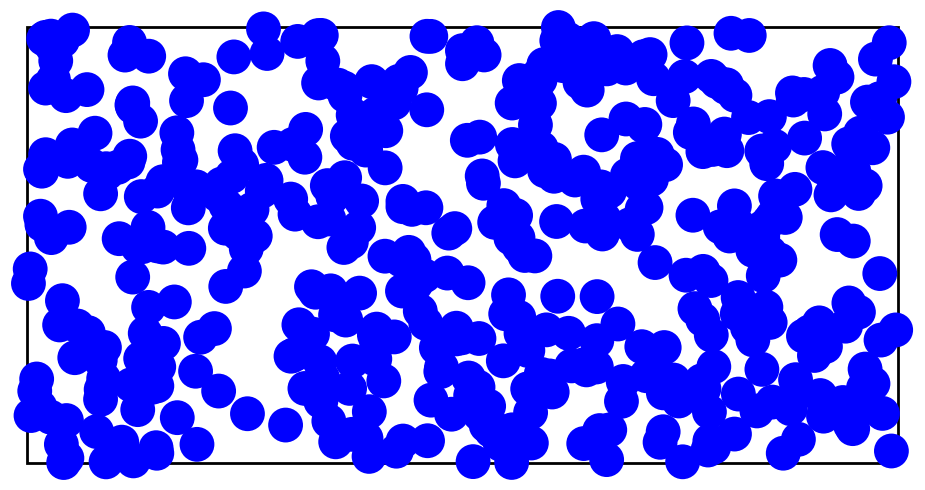

In [21]:
# Config
l1, l2 = 2.0, 1
lam = 0.40
n = 500

mu = n / (l1*l2)
r = np.sqrt(lam/mu)

npts = np.random.poisson(lam=n)
points = sample_in_rectangle(npts,l1,l2)
draw_boolean(points,r,l1,l2)

# Drawing the picture with colouring-by-size

To make the picture a tiny bit more interesting, I may colour each cluster by its size.

### Functions

In [22]:
from matplotlib import colormaps

def get_colour(p,min_col=0.0,max_col=1.0,palette="Blues"):
    """
    Given the proportion p of all the vertices contained in a given cluster,
    returns the colour we will use for that cluster as (r,g,b,a) 
    """
    c = colormaps[palette]
    normalised_p = min_col + (max_col - min_col)*p
    return c(normalised_p)

def coloured_clusters(points,r,l1,l2,rgg,min_col=0.0,max_col=1.0,palette="Blues"):
    fig, ax = plt.subplots()
    region = Rectangle((0,0),l1,l2,fill=False,linewidth=2)
    ax.add_patch(region)
    ax.set_xlim(-r,l1+r)
    ax.set_ylim(-r,l2+r)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    npts = points.shape[0]
    common_config = {'units':'x', 'transOffset':ax.transData}
    comps = [list(c) for c in networkx.connected_components(rgg)]
    for component in comps:
        c_size = len(component)
        p = c_size / npts
        comp_colour = get_colour(p,min_col,max_col,palette)
        comp_patch = EllipseCollection(np.full(c_size,2*r),np.full(c_size,2*r),
                                    np.zeros(c_size),
                                    offsets=points[component],
                                    facecolors=comp_colour,
                                    **common_config)
        ax.add_collection(comp_patch)
    plt.tight_layout()
    fig.savefig('diagrams/coloured_by_component.pdf')
    plt.show()
    plt.close()
    return

def add_to_axis(ax,points,r,l1,l2,rgg,min_col=0.0,max_col=1.0,palette="Blues"):
    region = Rectangle((0,0),l1,l2,fill=False,linewidth=0)
    ax.add_patch(region)
    ax.set_xlim(-r,l1+r)
    ax.set_ylim(-r,l2+r)
    ax.set_aspect(1.0)
    ax.set_axis_off()
    npts = points.shape[0]
    common_config = {'units':'x', 'transOffset':ax.transData}
    comps = [list(c) for c in networkx.connected_components(rgg)]
    for component in comps:
        c_size = len(component)
        p = c_size / npts
        comp_colour = get_colour(p,min_col,max_col,palette)
        comp_patch = EllipseCollection(np.full(c_size,2*r),np.full(c_size,2*r),
                                    np.zeros(c_size),
                                    offsets=points[component],
                                    facecolors=comp_colour,
                                    **common_config)
        ax.add_collection(comp_patch)
    return

### Plotting

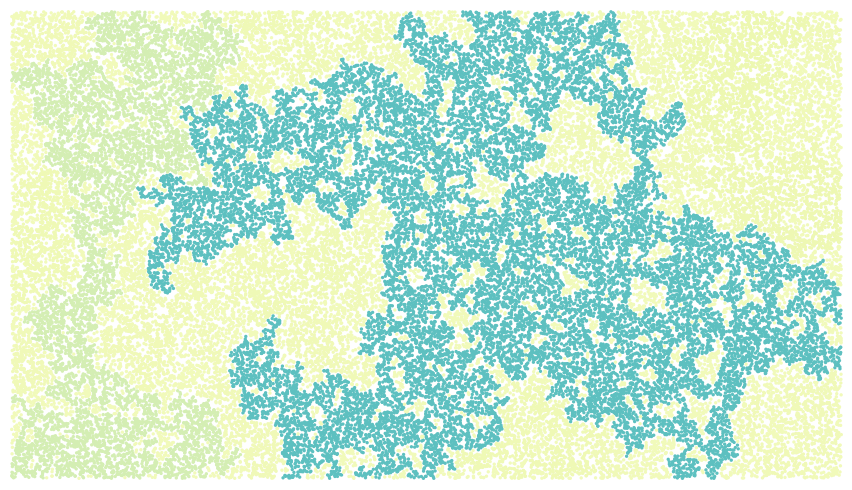

In [23]:
# Config
l1, l2 = 1920, 1080
lam = 0.36
n = 50000
min_col = 0.1
max_col = 0.9
palette="YlGnBu"

mu = n / (l1*l2)
r = np.sqrt(lam/mu)

npts = np.random.poisson(lam=n)
points = sample_in_rectangle(npts,l1,l2)
rgg = get_rgg(KDTree(points),r)
# coloured_clusters(points,r,l1,l2,rgg,min_col,max_col,palette)
fig, ax = plt.subplots()
add_to_axis(ax,points,r,l1,l2,rgg,min_col,max_col,palette)
plt.tight_layout()
fig.savefig("diagrams/bg.png",dpi=300)
plt.show()

## Little gallery

How about three side-by-side with an increasing value of $\lambda$?

100%|█████████████████████████████████████████████| 3/3 [01:08<00:00, 22.79s/it]


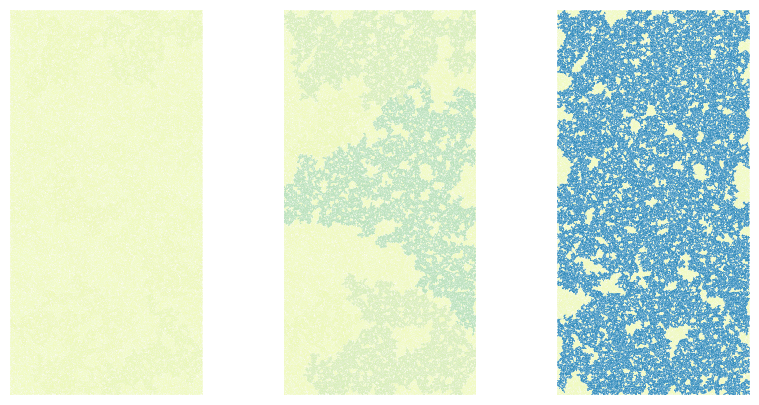

In [24]:
np.random.seed(13)

l1, l2 = 1, 2
lams = np.linspace(0.35,0.37,num=3) # lam = 0.36 is around the critical point
n = 500000
min_col = 0.1
max_col = 0.8
palette="YlGnBu"
## To reverse the spectrum, just swap min_col and max_col
# min_col = 1.0
# max_col = 0.0
# palette = "copper"

npts = np.random.poisson(lam=n)
points = sample_in_rectangle(npts,l1,l2)
points_tree = KDTree(points)
mu = n / (l1*l2)

fig, ax_list = plt.subplots(1,len(lams))
for i,ax in enumerate(tqdm(ax_list,leave=True)):
    lam = lams[i]
    r = np.sqrt(lam/mu)
    rgg = get_rgg(points_tree,r)
    add_to_axis(ax,points,r,l1,l2,rgg,min_col,max_col,palette)
fig.savefig("diagrams/phase-transition.png", dpi=400)
plt.show()
plt.close()

Once we've found a gallery we're happy with, we'll save each plot separately.

In [25]:
for lam in tqdm(lams,leave=True):
    r = np.sqrt(lam/mu)
    rgg = get_rgg(points_tree,r)
    fig, ax = plt.subplots(figsize=(l1, l2))
    add_to_axis(ax,points,r,l1,l2,rgg,min_col,max_col,palette)
    fig.savefig(f'diagrams/phase-{lam:.2f}.png',dpi=1600)
    plt.close()

100%|█████████████████████████████████████████████| 3/3 [01:11<00:00, 23.72s/it]


# Renormalisation diagram

We want to draw the "good event" used in the renormalisation argument.

In [158]:
K_COLOUR = "orange" # Some kind of pale orange
GOOD_PATH_COLOUR = "#000000" # Close to black?
GOOD_COMP_COLOUR = "#8080ff"

In [159]:
M = 1
K = 8
n = 5000
lam = 0.37

  9%|███▊                                       | 9/100 [00:00<00:03, 23.47it/s]


The good event occurred


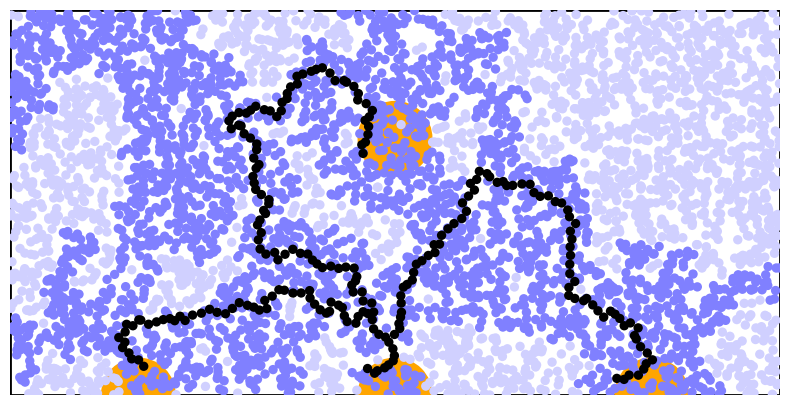

In [164]:
l1 = 3*M
l2 = 1.5*M
mu = n / (l1*l2)
r = np.sqrt(lam/mu)

centres = np.array( [[0.5*l1,0],[0.5*l1,M],[0.5*l1-M,0],[0.5*l1+M,0]] )



fig, ax = plt.subplots()
ax.set_xlim(0,l1)
ax.set_ylim(0,l2)
plt.gca().set_aspect(1.0)
plt.axis('off')
region = Rectangle((0,0),l1,l2,fill=False,linewidth=2)
ax.add_patch(region)
k_patch = EllipseCollection(np.full(4,2*K*r),np.full(4,2*K*r),
                                       np.zeros(4),units='x',transOffset=ax.transData,offsets=centres,
                                       facecolors=K_COLOUR)
ax.add_collection(k_patch)

# Now we determine if there is a path between each of the big discs.
# First, we get a list of vertices intersecting each disc.
for _ in trange(100): # The maximum number of attempts at getting a good diagram
    pts = sample_in_rectangle(n,l1,l2)
    points_tree = KDTree(pts)
    rgg = get_rgg(points_tree,r)
    vertices_lists = [[],[],[],[]]
    for i,c in enumerate(centres):
        vertices_lists[i] = points_tree.query_ball_point(c,(K+1)*r)
    # Next, we want to know if there is a single component intersecting all four balls
    comps = networkx.connected_components(rgg)
    all_good = False
    for comp in comps:
        good = True
        hitting_points = [None]*4
        for i,vl in enumerate(vertices_lists):
            candidates = [x for x in list(comp) if x in vl]
            if len(candidates) == 0:
                good = False
                break
            else:
                hitting_points[i] = candidates[0]
        if good:
            all_good = True
            good_comp = comp
            break
    if not all_good:
        continue
    else:
        print("The good event occurred")
        c0_pt = hitting_points[0]
        path_vertices = [c0_pt]
        for i in range(1,4):
            path = networkx.shortest_path(rgg,c0_pt,hitting_points[i])
            for v in path:
                if not v in path_vertices:
                    path_vertices.append(v)
        path_patch = EllipseCollection(np.full(len(path_vertices),2*r),np.full(len(path_vertices),2*r),
                                           np.zeros(len(path_vertices)),units='x',transOffset=ax.transData,offsets=pts[path_vertices],
                                           facecolors=GOOD_PATH_COLOUR)
        unused_good_vertices = [v for v in good_comp if not v in path_vertices]
        good_patch = EllipseCollection(np.full(len(unused_good_vertices),2*r),np.full(len(unused_good_vertices),2*r),
                                           np.zeros(len(unused_good_vertices)),units='x',transOffset=ax.transData,offsets=pts[unused_good_vertices],
                                           facecolors=GOOD_COMP_COLOUR)
        ax.add_collection(good_patch)
        ax.add_collection(path_patch)
        small_comps = [v for v in range(n) if not v in good_comp]
        small_patch = EllipseCollection(np.full(len(small_comps),2*r),np.full(len(small_comps),2*r),
                                           np.zeros(len(small_comps)),units='x',transOffset=ax.transData,offsets=pts[small_comps],
                                           facecolors=SMALL_COLOUR)
        ax.add_collection(small_patch)
        break
plt.show()
fig.savefig('diagrams/renormalisation.pdf',bbox_inches="tight")

# Frogs and lily pads

Last-minute slides for the SGSIA conference

Photos by "Dana", "Noodle Snacks" and "DaPuglet"

The idea is: two frogs are sat around the outside of a pond. Lily pads fall into the pond according to a homogeneous Poisson process for a certain time. How likely is it that the two frogs can meet?

It's just a different way of drawing the first diagram really.

#### Some functions for the new drawing

In [46]:
def draw_lilypads(points,r,l1,l2,thetax,thetay):
    fig, ax = plt.subplots()
    region = Ellipse((0,0),2*l1,2*l2,fill=True,facecolor="blue",linewidth=2, zorder=-5)
    ax.add_patch(region)
    ax.set_xlim(-l1-r,l1+r)
    ax.set_ylim(-l2-r,l2+r)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    xindex = len(points)-2
    yindex = len(points)-1
    if len(points) < 2000:
        with Image.open("small-lilypad.png") as lilypad:
            for i in trange(len(points)-2):
                plt.imshow(lilypad, extent=(points[i,0]-r,points[i,0]+r,points[i,1]-r,points[i,1]+r))
    else:
        patch = EllipseCollection(np.full(len(points),2*r),np.full(len(points),2*r),
                                        np.zeros(len(points)),units='x',transOffset=ax.transData,offsets=points,
                                        facecolors="#9ec434")
        ax.add_collection(patch)
    plt.show()
    fig.savefig(f'diagrams/just-lilypads.pdf')
    plt.close()

def lilypads_components(points,r,l1,l2,thetax,thetay,rgg):
    fig, ax = plt.subplots()
    region = Ellipse((0,0),2*l1,2*l2,fill=True,facecolor="blue",linewidth=2, zorder=-5)
    ax.add_patch(region)
    ax.set_xlim(-l1-r,l1+r)
    ax.set_ylim(-l2-r,l2+r)
    plt.gca().set_aspect(1.0)
    plt.axis('off')
    xindex = len(points)-2
    yindex = len(points)-1
    giant_cpt = list(max(networkx.connected_components(rgg),key=len)) # List of balls in the largest component
    if len(points) < 2000:
        with Image.open("small-lilypad.png") as lilypad:
            with Image.open("dark-lilypad.png") as darklilypad:
                for i in trange(len(points)):
                    if i in giant_cpt:
                        plt.imshow(lilypad, extent=(points[i,0]-r,points[i,0]+r,points[i,1]-r,points[i,1]+r))
                    else:
                        plt.imshow(darklilypad, extent=(points[i,0]-r,points[i,0]+r,points[i,1]-r,points[i,1]+r))
    else:
        patch = EllipseCollection(np.full(len(giant_cpt),2*r),np.full(len(giant_cpt),2*r),
                                        np.zeros(len(giant_cpt)),units='x',transOffset=ax.transData,offsets=points[giant_cpt],
                                        facecolors="#9ec434")
        ax.add_collection(patch)
        small_cpts = [i for i in range(len(points)) if not i in giant_cpt]
        small_patch = EllipseCollection(np.full(len(small_cpts),2*r),np.full(len(small_cpts),2*r),
                                        np.zeros(len(small_cpts)),units='x',transOffset=ax.transData,offsets=points[small_cpts],
                                        facecolors="#385400")
        ax.add_collection(small_patch)
    plt.show()
    fig.savefig(f'diagrams/comp-lilypads.pdf')
    plt.close()

In [143]:
l1 = 1.8
l2 = 1
thetax = -0.75*np.pi
thetay = 0.25*np.pi
n = 20000
npts = np.random.poisson(lam=n)
print(f'With intensity {n} we have {npts} points.')

points = sample_in_ellipse(npts,l1,l2)
xy = np.array([[l1*np.cos(thetax),l2*np.sin(thetax)], [l1*np.cos(thetay),l2*np.sin(thetay)]])
points = np.append(points,xy,axis=0)
xindex = npts
yindex = npts+1
points_tree = KDTree(points)


intensity = 0.37# The intensity of the corresponding continuum percolation.
mu = n / (np.pi * l1 * l2) # The intensity of the Poisson process for the Boolean model
r = np.sqrt(intensity / mu)

rgg = get_rgg(points_tree,r)

largest_comp = max(networkx.connected_components(rgg),key=len)
print(f'The largest component has {len(largest_comp)} vertices, {100*len(largest_comp)/npts:.1f} percent of the total vertices.')
try:
    path = networkx.shortest_path(rgg,xindex,yindex)
    print(f'There is a path of length {len(path)}')
    is_path = True
except Exception as e:
    print(f'No path from x to y at radius {r:.4f}')
    is_path = False
    if xindex in largest_comp:
        print("x is in the giant component")
    elif yindex in largest_comp:
        print("y is in the giant component")
    else:
        print("Neither x nor y is in the giant component")

With intensity 20000 we have 19910 points.
The largest component has 15085 vertices, 75.8 percent of the total vertices.
There is a path of length 354


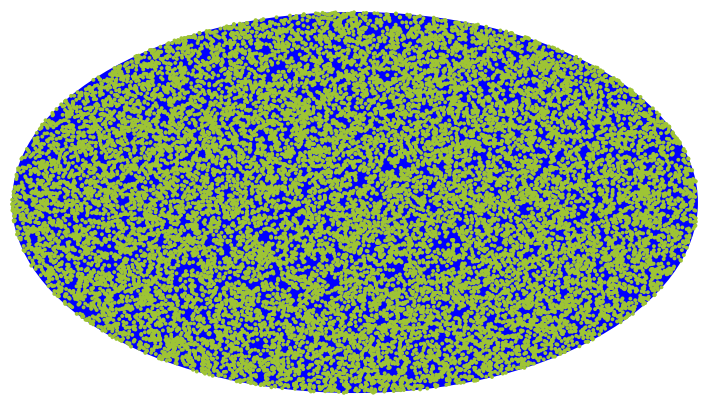

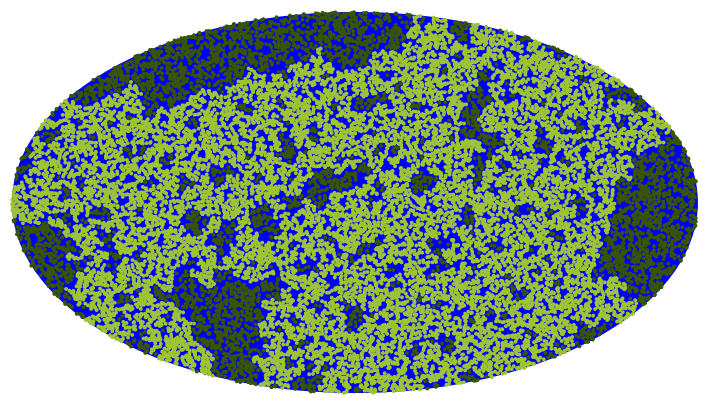

In [144]:
draw_lilypads(points,r,l1,l2,thetax,thetay)
lilypads_components(points,r,l1,l2,thetax,thetay,rgg)